In [7]:
from openbabel import openbabel

In [8]:
from rdkit import Chem
from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [82]:
path1 = './NoStereoFormoseAmm.tsv'
path2 = './NoStereoFormoseFinal_CHNO.tsv'
path3 = './NoStereoGlucoseAmm.txt'
path4 = './NoStereoGlucoseFinal_CHNO.txt'
path5 = './NoStereoPyruvicAcid_CHNO.txt'

In [42]:
hmdbpath = "./Databases/hmdb.sdf"
hmdb=Chem.SDMolSupplier(hmdbpath)  # Load sdf

In [43]:
keggpath = './Databases/kegg.tsv'

In [13]:
def molweight(array, position):
    Smi = array[position]
    mol = Chem.MolFromSmiles(Smi)
    weight = Descriptors.ExactMolWt(mol)
    return(weight)

In [14]:
def maximum_mass(matches, position):
    matches_data = pd.read_csv(matches, sep='\t')
    matches_data['Molecular Weight'] = matches_data.apply(molweight, axis=1, raw=True, result_type='expand', args=[position])
    max_mass = max(matches_data['Molecular Weight'])
    return(max_mass)

In [15]:
def db_parse(smiles_list, matches, position):
    max_mass = maximum_mass(matches, position)
    valid_smiles = []
    for i in range(len(smiles_list)):
        try:
            mol = Chem.MolFromSmiles(smiles_list[i])
            weight = Descriptors.ExactMolWt(mol)
            if weight <= max_mass:
                valid_smiles.append(smiles_list[i])
        except:
            print()
    valid_data = {'Smiles': valid_smiles}
    df = pd.DataFrame(valid_data)
    return(df)

In [16]:
def split(word):
    return[char for char in word]

In [17]:
def inchi(array):
    Smiles = array[0] 
    mol = Chem.MolFromSmiles(Smiles)
    dummy = Chem.inchi.MolToInchiKey(mol)#split at first layer (contains everything but stereochemical info)
    characters = split(dummy)
    dummy = ''
    position = 0
    for i in range(len(characters)):
        if characters[i] == '-':
            position = i
            break
    for i in range(position):
        dummy += characters[i]
    return(dummy)

In [18]:
def inchi_generations(array):
    Smiles = array[1]
    mol = Chem.MolFromSmiles(Smiles)
    dummy = Chem.inchi.MolToInchiKey(mol)#split at first layer (contains everything but stereochemical info)
    characters = split(dummy)
    dummy = ''
    position = 0
    for i in range(len(characters)):
        if characters[i] == '-':
            position = i
            break
    for i in range(position):
        dummy += characters[i]
    return(dummy)

In [19]:
def prep_data(library_set, test_set): #input filepaths for the 2 sets as tsv files
    test_data = pd.read_csv(test_set, sep='\t')
    library_data = library_set
    print(1)
    test_data['Inchi'] = test_data.apply(inchi_generations, axis=1, raw=True, result_type='expand')
    print(2)
    library_data['Inchi'] = library_data.apply(inchi, axis=1, raw=True, result_type='expand')
    #Using degeneracy removed datasets with Inchikey already found 
    return(library_data, test_data)

In [20]:
def find_matches(library_set, test_set):
    library_data, test_data = prep_data(library_set, test_set)
    print(3)
    test_codes = []
    for i in range(len(test_data['Inchi'])):
        test_codes.append(test_data['Inchi'][i])
    library_codes = []
    for i in range(len(library_data['Inchi'])):
        library_codes.append(library_data['Inchi'][i])
    print(4)
    matches = []
    for i in range(len(test_codes)):
        if test_codes[i] in library_codes:
            matches.append(test_codes[i])
    print(5)
    test_smiles = []
    library_smiles = []
    matches_generations = []
    for i in range(len(matches)):
        for j in range(len(test_data['Inchi'])):
            if matches[i] == test_data['Inchi'][j]:
                test_smiles.append(test_data['Smiles'][j])
                matches_generations.append(test_data['Generation'][j])
                break
        #for k in range(len(library_data['Inchi'])):
            #if matches[i] == library_data['Inchi'][k]:
                #library_smiles.append(library_data['Smiles'][k])
    #matches_data = {'Generation': matches_generations, 'Test Smiles': test_smiles, 'Library Smiles': library_smiles, 'Inchi': matches}
    matches_data = {'Generation': matches_generations, 'Smiles': test_smiles, 'Inchi': matches}
    library_test_matches = pd.DataFrame(matches_data)
    return(library_test_matches)

In [21]:
def prep_databasefromSDF(db_path, matches_path, position):
    db = Chem.SDMolSupplier(db_path)
    dbsmiles = []
    for mol in db:
        try:
            dbsmiles.append(Chem.MolToSmiles(mol)) 
        except:
            pass
    df = db_parse(dbsmiles, matches_path, position)
    return(df)

In [22]:
def prep_databasefromTSV(db_path, matches_path, position):
    db = pd.read_csv(db_path, sep='\t')
    dbsmiles = []
    for i in range(len(db['Smiles'])):
        dbsmiles.append(db['Smiles'][i])
    df = db_parse(dbsmiles, matches_path, position)
    return(df)

In [83]:
%%time
prepped_db1 = prep_databasefromSDF(hmdbpath, path2, 1)

RDKit ERROR: [20:10:52] ERROR: Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [20:12:25] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [20:12:25] ERROR: Could not sanitize molecule ending on line 103252
RDKit ERROR: [20:12:25] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [20:12:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [20:12:25] ERROR: Could not sanitize molecule ending on line 208352
RDKit WARNING: [20:12:26] Warning: conflicting stereochemistry at atom 12 ignored. by rule 1a.
RDKit WARNING: [20:12:26] Warning: conflicting stereochemistry at atom 12 ignored. by rule 1a.
RDKit ERROR: [20:12:25] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [20:12:26] Explicit valence for atom # 0 P, 11, is greater than permitted
RDKit ERROR: [20:12:26] ERROR: Could not sanitize molecule ending on line 436746
RDKit WARNING: [20:12:26] 

RDKit WARNING: [20:14:12] WARNING: not removing hydrogen atom without neighbors



CPU times: user 2min 16s, sys: 1.15 s, total: 2min 17s
Wall time: 2min 18s


RDKit ERROR: [20:14:43] Explicit valence for atom # 17 O, 3, is greater than permitted


In [84]:
%%time
prepped_db2 = prep_databasefromTSV(keggpath, path2, 1)

RDKit ERROR: [20:14:44] Explicit valence for atom # 1 N, 4, is greater than permitted


RDKit ERROR: [20:14:45] Explicit valence for atom # 13 N, 4, is greater than permitted


RDKit ERROR: [20:14:46] Explicit valence for atom # 0 Ca, 4, is greater than permitted
RDKit ERROR: [20:14:46] Explicit valence for atom # 0 Mg, 4, is greater than permitted





CPU times: user 3.38 s, sys: 16.6 ms, total: 3.4 s
Wall time: 3.41 s


RDKit ERROR: [20:14:46] Explicit valence for atom # 0 Ca, 4, is greater than permitted


In [25]:
def generations_counter(input_data, num_generations):
    gen_data = np.zeros(num_generations+1)
    value_data = np.zeros(num_generations+1)
    
    for i in range(len(gen_data)):
        gen_data[i] = i
        
    for i in range(len(input_data['Generation'])):
        dummy = split(input_data['Generation'][i])
        value = int(dummy[-1])
        value_data[value]+=1
    
    final_value_data = np.zeros(num_generations+1)
    for i in range(1, len(value_data)):
        final_value_data[i] += value_data[i]
        for j in range(i):
            final_value_data[i] += value_data[j]
    
    return(gen_data, final_value_data)

In [28]:
def generations_plot(input_data, num_generations):
    gen_data, final_value_data = generations_counter(input_data, num_generations)
    plt.plot(gen_data, final_value_data, linestyle='--', marker='o')

In [31]:
def database_matches_plot(prepped_db1, prepped_db2, matches_path, num_generations, title):
    db_matches1 = find_matches(prepped_db1, matches_path)
    db_matches2 = find_matches(prepped_db2, matches_path)
    plt.figure(figsize = (10,8))
    generations_plot(db_matches1, num_generations)
    generations_plot(db_matches2, num_generations)
    generations_plot(pd.read_csv(matches_path, sep='\t'), num_generations)
    plt.xlabel('Generation')
    plt.ylabel('Cumulative Matches')
    plt.legend(['HMDB Matches', 'Kegg Matches', 'Computed set'])
    plt.yscale('symlog')
    plt.xticks(np.arange(0, num_generations+1, step=1))
    plt.title(f'{title}')

In [37]:
def database_data(prepped_db1, prepped_db2, matches_path, num_generations):
    db_matches1 = find_matches(prepped_db1, matches_path)
    db_matches2 = find_matches(prepped_db2, matches_path)
    
    gen_data1, final_value_data1 = generations_counter(db_matches1, num_generations)
    gen_data2, final_value_data2 = generations_counter(db_matches2, num_generations)
    
    database = {'Generation': gen_data1, 'HMDB': final_value_data1, 'Kegg': final_value_data2}
    df = pd.DataFrame(database)
    return(df)

In [85]:
df = database_data(prepped_db1, prepped_db2, path2, 5)

1
2


RDKit WARNING: [20:14:48] WARNING: not removing hydrogen atom without neighbors


3
4
5
1
2
3
4
5


In [86]:
df

,Generation,HMDB,Kegg
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,2.0,7.0,7.0
3,3.0,17.0,16.0
4,4.0,32.0,28.0
5,5.0,42.0,41.0


In [72]:
df.to_csv('GlucoseDatabaseMatches.tsv', header=None, index=None, sep='\t', mode='a')

1
2


RDKit WARNING: [20:14:53] WARNING: not removing hydrogen atom without neighbors


3
4
5
1
2
3
4
5


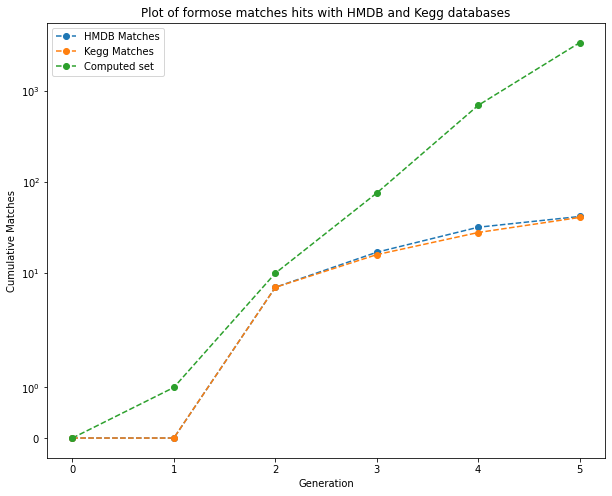

In [87]:
database_matches_plot(prepped_db1, prepped_db2, path2, 5, 'Plot of formose matches hits with HMDB and Kegg databases')